# Fire and smoke detection with Deep Learning
## Yordan Penev

## Abstract

Our goal is to train an object detector capable of real-time accurately detecting fire and smoke using Computer Vision, OpenCV, and the Keras Deep Learning library.

### We will use two datasets.
### 1. Fire and smoke dataset
The dataset we’ll be using for fire and smoke examples was curated by Gautam Kumar.

Guatam gathered a total of 1,315 images by searching Google Images for queries related to the term “fire”, “smoke”, etc.

The original dataset has not been cleansed of extraneous, irrelevant images that are not related to fire and smoke (i.e., examples of famous buildings before a fire occurred).

However, David Bonn, took the time to manually go through the fire/smoke images and identify ones that should not be included.


### 2. The 8-scenes dataset
The dataset we’ll be using for Non-fire examples is called 8-scenes as it contains 2,688 image examples belonging to eight natural scene categories (all without fire):
- Coast
- Mountain
- Forest
- Open country
- Street
- Inside city
- Tall buildings
- Highways


The dataset was originally curated by Oliva and Torralba in their 2001 paper, Modeling the shape of the scene: a holistic representation of the spatial envelope.

The 8-scenes dataset is a natural complement to our fire/smoke dataset as it depicts natural scenes as they should look without fire or smoke present.

While this dataset has 8 unique classes, we will consider the dataset as a single Non-fire class when we combine it with Gautam’s Fire dataset.

### Configuration

In [1]:
# import the necessary packages
import os
# initialize the path to the fire and non-fire dataset directories
FIRE_PATH = os.path.sep.join(["Robbery_Accident_Fire_Database2", "Fire"])
NON_FIRE_PATH = "spatial_envelope_256x256_static_8outdoorcategories"
# initialize the class labels in the dataset
CLASSES = ["Non-Fire", "Fire"]

In [2]:
# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["output", "fire_detection.model"])
# define the path to the output learning rate finder plot and
# training history plot
LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])

### Loading data

In [3]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
#matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import cv2
import sys

In [4]:
def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory, then
    # initialize our lists of images
    imagePaths = list(paths.list_images(datasetPath))
    data = []
    # loop over the image paths
    for imagePath in imagePaths:
        # load the image and resize it to be a fixed 128x128 pixels,
        # ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (128, 128))
        # add the image to the data lists
        data.append(image)
    # return the data list as a NumPy array
    return np.array(data, dtype="float32")

In [5]:
# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset(FIRE_PATH)
nonFireData = load_dataset(NON_FIRE_PATH)
# construct the class labels for the data
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])
data /= 255

print("[INFO] ", len(fireData), " FIRE and ", len(nonFireData), " NON FIRE images loaded.")

[INFO] loading data...
[INFO]  1405  FIRE and  2688  NON FIRE images loaded.


### Implementing Convolutional Neural Network

This network utilizes depthwise separable convolution rather than standard convolution as depthwise separable convolution:

- Is more efficient, as Edge/IoT devices will have limited CPU and power draw.
- Requires less memory, as again, Edge/IoT devices have limited RAM.
- Requires less computation, as we have limited CPU horsepower.
- Can perform better than standard convolution in some cases, which can lead to a better fire/smoke detector.

In [6]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


In [7]:
class FireDetectionNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        # CONV => RELU => POOL
        model.add(SeparableConv2D(16, (7, 7), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # CONV => RELU => POOL
        model.add(SeparableConv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # (CONV => RELU) * 2 => POOL
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        # second set of FC => RELU layers
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        # return the constructed network architecture
        return model

### Preparing data

In [8]:
# define the size of the training and testing split
TRAIN_SPLIT = 0.75
TEST_SPLIT = 0.25

# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-2
BATCH_SIZE = 64
NUM_EPOCHS = 50

In [9]:
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=TEST_SPLIT, random_state=42)

In [10]:
# initialize the training data augmentation object
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = FireDetectionNet.build(width=128, height=128, depth=3, classes=2)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


### Traning model

In [11]:
# train the network
print("[INFO] training network...")


H = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    #class_weight=classWeight,
    verbose=1)

[INFO] training network...
Epoch 1/50
47/47 [==============================] - 69s 1s/step - loss: 0.7835 - accuracy: 0.6573 - val_loss: 0.7684 - val_accuracy: 0.6348
Epoch 2/50
47/47 [==============================] - 65s 1s/step - loss: 0.5044 - accuracy: 0.7846 - val_loss: 1.0171 - val_accuracy: 0.6348
Epoch 3/50
47/47 [==============================] - 66s 1s/step - loss: 0.4723 - accuracy: 0.7927 - val_loss: 1.2070 - val_accuracy: 0.6348
Epoch 4/50
47/47 [==============================] - 66s 1s/step - loss: 0.4287 - accuracy: 0.8151 - val_loss: 1.2844 - val_accuracy: 0.6348
Epoch 5/50
47/47 [==============================] - 65s 1s/step - loss: 0.3742 - accuracy: 0.8326 - val_loss: 1.3538 - val_accuracy: 0.6348
Epoch 6/50
47/47 [==============================] - 66s 1s/step - loss: 0.3813 - accuracy: 0.8339 - val_loss: 1.4270 - val_accuracy: 0.6348
Epoch 7/50
47/47 [==============================] - 66s 1s/step - loss: 0.3378 - accuracy: 0.8501 - val_loss: 1.4199 - val_accuracy: 

### Evaluatng model

[INFO] evaluating network...
              precision    recall  f1-score   support

    Non-Fire       0.99      0.34      0.51       650
        Fire       0.46      0.99      0.63       374

    accuracy                           0.58      1024
   macro avg       0.73      0.67      0.57      1024
weighted avg       0.80      0.58      0.55      1024

[INFO] serializing network to 'output\fire_detection.model'...
INFO:tensorflow:Assets written to: output\fire_detection.model\assets


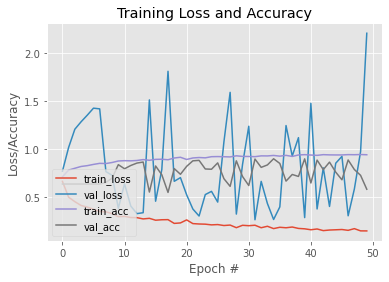

In [12]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=CLASSES))
# serialize the model to disk
print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
model.save(MODEL_PATH)
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)
plt.show()
plt.close()

### Test with different parameters

In [13]:
INIT_LR = 1e-2
BATCH_SIZE = 64
NUM_EPOCHS = 50

In [14]:
# initialize the training data augmentation object
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = FireDetectionNet.build(width=128, height=128, depth=3, classes=2)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [15]:
# train the network
print("[INFO] training network...")


H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    #class_weight=classWeight,
    verbose=1)

[INFO] training network...


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
47/47 [==============================] - 66s 1s/step - loss: 0.7235 - accuracy: 0.6898 - val_loss: 0.6836 - val_accuracy: 0.6348
Epoch 2/50
47/47 [==============================] - 65s 1s/step - loss: 0.4774 - accuracy: 0.7873 - val_loss: 0.7297 - val_accuracy: 0.6348
Epoch 3/50
47/47 [==============================] - 64s 1s/step - loss: 0.4553 - accuracy: 0.7814 - val_loss: 0.6875 - val_accuracy: 0.6348
Epoch 4/50
47/47 [==============================] - 64s 1s/step - loss: 0.3958 - accuracy: 0.8179 - val_loss: 0.7203 - val_accuracy: 0.6348
Epoch 5/50
47/47 [==============================] - 65s 1s/step - loss: 0.3739 - accuracy: 0.8341 - val_loss: 0.7503 - val_accuracy: 0.6348
Epoch 6/50
47/47 [==============================] - 65s 1s/step - loss: 0.3553 - accuracy: 0.8409 - val_loss: 0.7875 - val_accuracy: 0.6348
Epoch 7/50
47/47 [==============================] - 64s 1s/step - loss: 0.3353 - accuracy: 0.8593 - val_loss: 0.6034 - val_accuracy: 0.6445
Epoch 8/50
47/47 [==

### Second evaluating

[INFO] evaluating network...
              precision    recall  f1-score   support

    Non-Fire       0.93      0.92      0.93       650
        Fire       0.86      0.89      0.87       374

    accuracy                           0.91      1024
   macro avg       0.90      0.90      0.90      1024
weighted avg       0.91      0.91      0.91      1024

[INFO] serializing network to 'output\fire_detection.model'...
INFO:tensorflow:Assets written to: output\fire_detection.model\assets


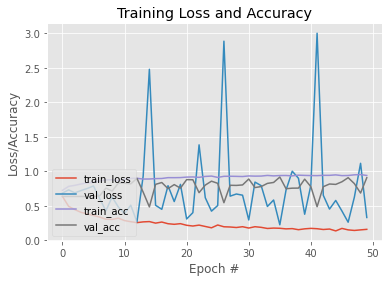

In [16]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=CLASSES))
# serialize the model to disk
print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
model.save(MODEL_PATH)
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)
plt.show()
plt.close()

### Making predictions on fire/non-fire images

In [28]:
# import the necessary packages
from tensorflow.keras.models import load_model
from imutils import paths
import numpy as np
import imutils
import random
import cv2
import os
# load the trained model from disk
print("[INFO] loading model...")
model = load_model(MODEL_PATH)

[INFO] loading model...


In [32]:
# define the path to the output directory that will store our final
# output with labels/annotations along with the number of images to
# sample
OUTPUT_IMAGE_PATH = os.path.sep.join(["output", "examples"])
SAMPLE_SIZE = 5

In [33]:
# grab the paths to the fire and non-fire images, respectively
print("[INFO] predicting...")
firePaths = list(paths.list_images(FIRE_PATH))
nonFirePaths = list(paths.list_images(NON_FIRE_PATH))
# combine the two image path lists, randomly shuffle them, and sample
# them
imagePaths = firePaths + nonFirePaths
random.shuffle(imagePaths)
imagePaths = imagePaths[:SAMPLE_SIZE]

[INFO] predicting...


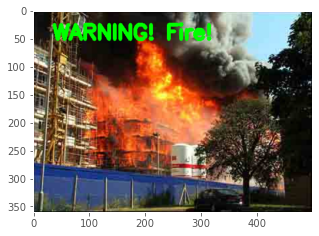

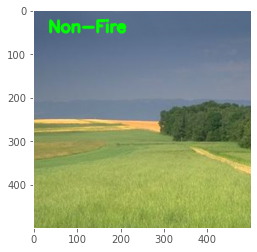

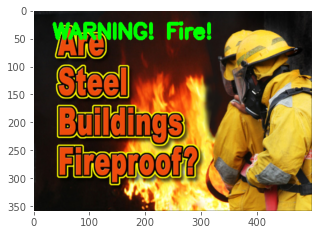

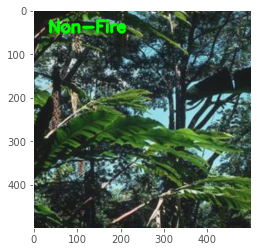

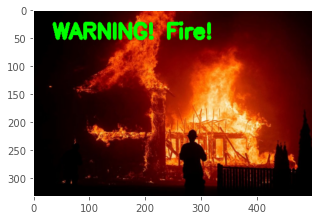

In [34]:
# loop over the sampled image paths
for (i, imagePath) in enumerate(imagePaths):
    # load the image and clone it
    image = cv2.imread(imagePath)
    output = image.copy()
    # resize the input image to be a fixed 128x128 pixels, ignoring
    # aspect ratio
    image = cv2.resize(image, (128, 128))
    image = image.astype("float32") / 255.0
        
    # make predictions on the image
    preds = model.predict(np.expand_dims(image, axis=0))[0]
    j = np.argmax(preds)
    label = CLASSES[j]
    # draw the activity on the output frame
    text = label if label == "Non-Fire" else "WARNING! Fire!"
    output = imutils.resize(output, width=500)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
        1.25, (0, 255, 0), 5)
    # write the output image to disk	 
    filename = "{}.png".format(i)
    p = os.path.sep.join([OUTPUT_IMAGE_PATH, filename])
    cv2.imwrite(p, output)
    
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(5, 4)
    
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.rcParams["axes.grid"] = False
    plt.imshow(output)
    plt.show()

### Conclusion
Our results are good, but not perfect. Many of the example images in our fire/smoke dataset contained examples of professional photos captured by news reports. Fires don’t look like that in the wild.

In order to improve our fire and smoke detection model, we need better data.

Future efforts in fire/smoke detection research should focus less on the actual deep learning architectures/training methods and more on the actual dataset gathering and curation process, ensuring the dataset better represents how fires start, smolder, and spread in natural scene images.

### Bibliography
1. Adrian Rosebrock. Fire and smoke detection with Keras and Deep Learning. Retrieved from:
[https://www.pyimagesearch.com/2019/11/18/fire-and-smoke-detection-with-keras-and-deep-learning/](https://www.pyimagesearch.com/2019/11/18/fire-and-smoke-detection-with-keras-and-deep-learning/)
2. Fire/smoke dataset. Retrieved from:
[https://drive.google.com/file/d/11KBgD_W2yOxhJnUMiyBkBzXDPXhVmvCt/view?usp=sharing](https://drive.google.com/file/d/11KBgD_W2yOxhJnUMiyBkBzXDPXhVmvCt/view?usp=sharing)
3. 8-scenes dataset. Retrieved from:
[https://people.csail.mit.edu/torralba/code/spatialenvelope/spatial_envelope_256x256_static_8outdoorcategories.zip](https://people.csail.mit.edu/torralba/code/spatialenvelope/spatial_envelope_256x256_static_8outdoorcategories.zip)